Display the performance of ensemble with varying datasets and models.

In [5]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# modify this to set up directory:
DATA_DIR = "/home/data/wangz56"

model = "resnet56"
attack_list = ["losstraj", "reference", "lira", "calibration"]
# dataset_list = ["cifar10", "cifar100", "cinic10", "texas100", "purchase100"]
dataset_list = ["cifar10", "cifar100", "cinic10"]
ensemble_method_list = ["union", "intersection", "majority_vote"]
seeds = [0, 1, 2, 3, 4, 5]
path_to_data = f'{DATA_DIR}/miae_standard_exp'
path_to_save_result = f'{path_to_data}/ensemble_roc/performance_comp'
if os.path.exists(path_to_save_result) == False:
    os.makedirs(path_to_save_result)

In [6]:
def load_ensemble_perf(dataset, num_seed, ensemble_method, path_to_data):
    path_to_df = f"{path_to_data}/ensemble_roc/{model}/{dataset}/{num_seed}_seeds/{ensemble_method}"
    df = pd.read_pickle(f"{path_to_df}/ensemble_perf.pkl")
    return df

Convert roc and acc of multiple dataset to a csv table.

In [7]:
from copy import deepcopy
perf_union_df_dict = {}
perf_intersection_df_dict = {}
perf_majority_vote_df_dict = {}
for num_seed in range(2, len(seeds)+1):
    # merge to a single dataframe
    # rows: Ensemble Level, losstraj, reference, lira, calibration, dataset, ensemble_method, auc, acc
    for ensemble in ensemble_method_list:
        perf_df = pd.DataFrame(columns=["Ensemble Level", "losstraj", "reference", "lira", "calibration", "dataset", "AUC", "ACC", "TPR@0.001FPR"]
                               ).astype({"AUC": float, "ACC": float, "losstraj": bool, "reference": bool, "lira": bool, "calibration": bool})
        for dataset in dataset_list:
            df = load_ensemble_perf(dataset, num_seed, ensemble, path_to_data)
            for _, row in df.iterrows():
                if row["Ensemble Level"] == 'Multi Instances':
                    continue # skip multi instances
                ensemble_level = row["Ensemble Level"]
                auc = row["AUC"]
                acc = row["ACC"]
                attack_names = row["Attack"].split("_")
                losstraj = "losstraj" in attack_names
                reference = "reference" in attack_names
                lira = "lira" in attack_names
                calibration = "calibration" in attack_names
                new_entry = {"Ensemble Level": ensemble_level, "losstraj": losstraj, "reference": reference, "lira": lira, "calibration": calibration, "dataset": dataset, 
                             "AUC": auc, "ACC": acc, "TPR@0.001FPR": row["TPR@0.001FPR"]}
                new_entry = pd.DataFrame([new_entry]).astype(perf_df.dtypes.to_dict())
                perf_df = pd.concat([perf_df, new_entry], ignore_index=True)

        # save to csv
        perf_df.to_csv(f"{path_to_save_result}/{ensemble}_ensemble_{num_seed}seeds_perf.csv", index=False)
        if ensemble == "union":
            perf_union_df_dict[num_seed] = deepcopy(perf_df)
        elif ensemble == "intersection":
            perf_intersection_df_dict[num_seed] = deepcopy(perf_df)
        elif ensemble == "majority_vote":
            perf_majority_vote_df_dict[num_seed] = deepcopy(perf_df)

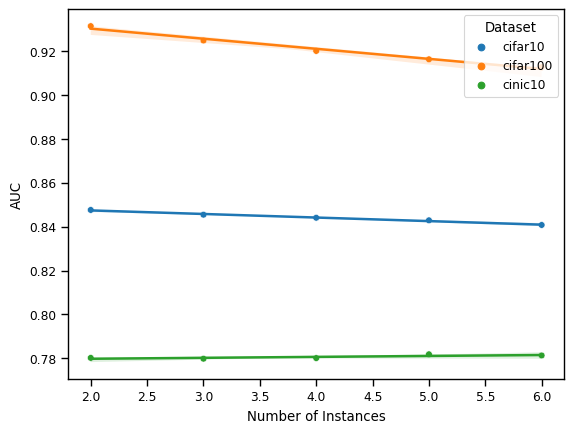

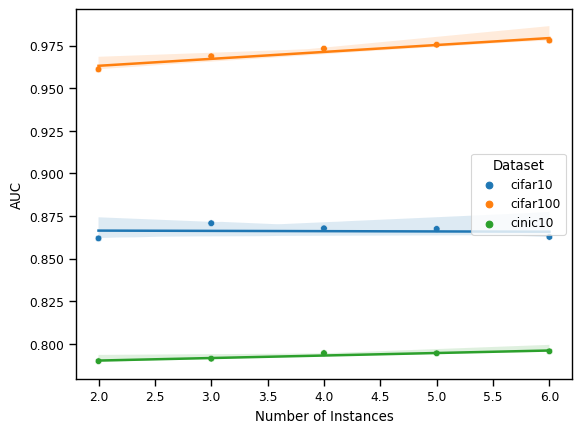

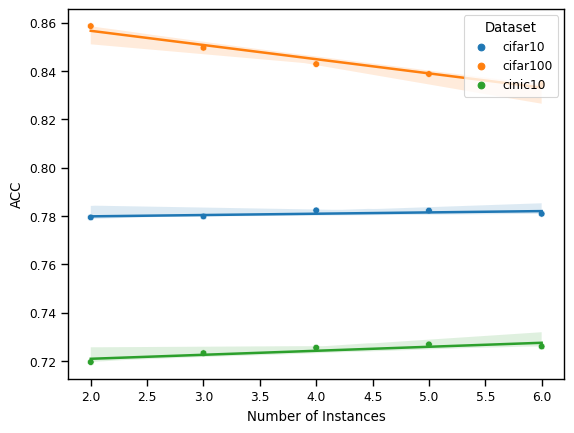

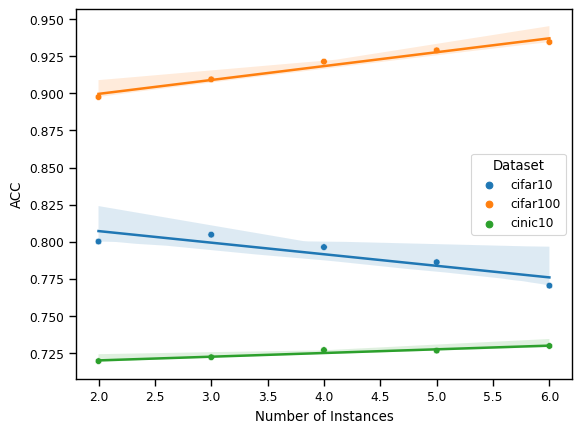

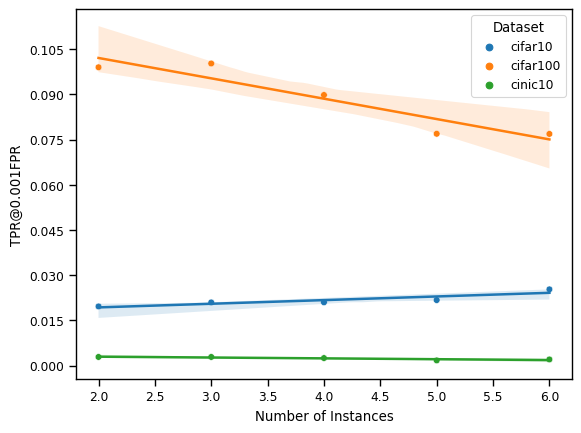

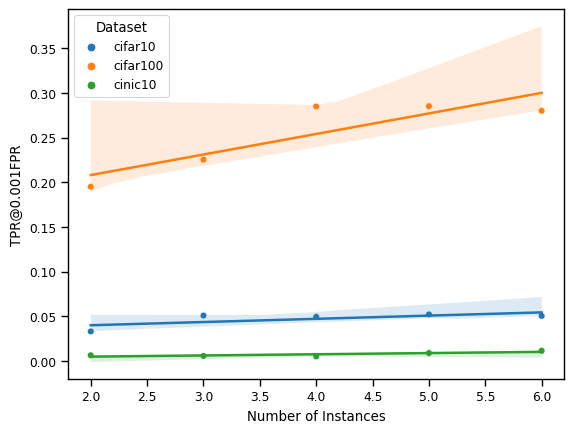

In [8]:
import numpy as np  # Make sure to import numpy for polyfit and poly1d

sns.set_context("paper")
# plot auc and acc of 4-attack_multi_attck ensemble from each dataset for different number of instances
for y_axis, ensemble_method in itertools.product(["AUC", "ACC", "TPR@0.001FPR"], ["union", "intersection"]):
    fig, ax = plt.subplots()
    temp_df = pd.DataFrame(columns=["dataset", "num_seed", y_axis]).astype({y_axis: float, "num_seed": int})
    for dataset in dataset_list:
        for num_seed in range(2, len(seeds)+1):
            # set a pointer to the correct dataframe
            perf_df_dict = perf_union_df_dict if ensemble_method == "union" else perf_intersection_df_dict
            perf_df = perf_df_dict[num_seed]
            perf_df = perf_df[
                (perf_df["dataset"] == dataset) & 
                (perf_df["losstraj"] == True) & 
                (perf_df["reference"] == True) & 
                (perf_df["lira"] == True) & 
                (perf_df["calibration"] == True)
            ]
            # make sure there is only one row
            if len(perf_df) != 1:
                # collect the names for the attacks
                attack_names = []
                for _, row in perf_df.iterrows():
                    print(row)
                # print(f"More than one row for {dataset} {num_seed} seeds: {attack_names}")
                raise ValueError(f"More than one row for {dataset} {num_seed} seeds")
            y_val = perf_df[y_axis].values[0]
            new_row = pd.DataFrame([{"dataset": dataset, "num_seed": num_seed, y_axis: y_val}])
            temp_df = pd.concat([temp_df, new_row], ignore_index=True)

    # Plot scatter points
    sns.scatterplot(data=temp_df, x="num_seed", y=y_axis, hue="dataset", ax=ax)
    # Get the current color palette
    palette = sns.color_palette()
    # Get the mapping of dataset to color
    dataset_unique = temp_df['dataset'].unique()
    palette_dict = dict(zip(dataset_unique, palette))

    # Loop over datasets and plot trend lines
    for dataset in dataset_unique:
        dataset_df = temp_df[temp_df['dataset'] == dataset]
        sns.regplot(
            data=dataset_df, x="num_seed", y=y_axis, 
            scatter=False, color=palette_dict[dataset], ax=ax, label=None
        )

    ax.set_ylabel(y_axis)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xlabel("Number of Instances")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[:len(dataset_unique)], labels=labels[:len(dataset_unique)], title='Dataset')
    plt.savefig(f"{path_to_save_result}/num_seed_vs_{y_axis}_{ensemble_method}_ensemble.pdf", bbox_inches='tight', format='pdf')

Create a new csv to display the performance of ensemble with varying datasets and models.

In [9]:
"""
The columns shall be:
Ensemble_level, cifar10_auc, cifar10_acc, cifar100_auc, cifar100_acc, cinic10_auc, cinic10_acc, texas100_auc, texas100_acc, purchase100_auc, purchase100_acc
"""
# print out the multi-attack ensemble's entry with all attacks

num_seed = 6
# for ensemble_method in ensemble_method_list:
for ensemble_method in ensemble_method_list:
    result_df = pd.DataFrame(columns=["Ensemble_level", "attack" , "cifar10_auc", "cifar10_acc", "cifar100_auc", "cifar100_acc", "cinic10_auc", "cinic10_acc", "texas100_auc", "texas100_acc", "purchase100_auc", "purchase100_acc"])
    # handle rows for single attack

    perf_df = perf_union_df_dict[num_seed] if ensemble_method == "union" else perf_intersection_df_dict[num_seed]
    for attack in attack_list:
        perf_i = perf_df[(perf_df[attack] == True) & (perf_df["Ensemble Level"] == "Single Instance")]
        cifar10_auc = perf_i[perf_i["dataset"] == "cifar10"]["AUC"].values[0]
        cifar10_acc = perf_i[perf_i["dataset"] == "cifar10"]["ACC"].values[0]
        cifar100_auc = perf_i[perf_i["dataset"] == "cifar100"]["AUC"].values[0]
        cifar100_acc = perf_i[perf_i["dataset"] == "cifar100"]["ACC"].values[0]
        cinic10_auc = perf_i[perf_i["dataset"] == "cinic10"]["AUC"].values[0]
        cinic10_acc = perf_i[perf_i["dataset"] == "cinic10"]["ACC"].values[0]
        texas100_auc = perf_i[perf_i["dataset"] == "texas100"]["AUC"].values[0]
        texas100_acc = perf_i[perf_i["dataset"] == "texas100"]["ACC"].values[0]
        purchase100_auc = perf_i[perf_i["dataset"] == "purchase100"]["AUC"].values[0]
        purchase100_acc = perf_i[perf_i["dataset"] == "purchase100"]["ACC"].values[0]
        new_row = pd.DataFrame([{"Ensemble_level": "Single Instances", "attack": attack, 
                                 "cifar10_auc": cifar10_auc, "cifar10_acc": cifar10_acc, 
                                 "cifar100_auc": cifar100_auc, "cifar100_acc": cifar100_acc,
                                 "cinic10_auc": cinic10_auc, "cinic10_acc": cinic10_acc, 
                                 "texas100_auc": texas100_auc, "texas100_acc": texas100_acc,
                                   "purchase100_auc": purchase100_auc, "purchase100_acc": purchase100_acc}])
                
        result_df = pd.concat([result_df, new_row], ignore_index=True)

    # handle rows for multi attack, preserving only the multi attack with all 4 attacks
    perf_df = perf_union_df_dict[num_seed] if ensemble_method == "union" else perf_intersection_df_dict[num_seed]
    
    perf_i = perf_df[(perf_df["Ensemble Level"] == "Multi Attacks") & (perf_df["losstraj"] == True) & (perf_df["reference"] == True) & (perf_df["lira"] == True) & (perf_df["calibration"] == True)]
    cifar10_auc = perf_i[perf_i["dataset"] == "cifar10"]["AUC"].values[0]
    cifar10_acc = perf_i[perf_i["dataset"] == "cifar10"]["ACC"].values[0]
    cifar100_auc = perf_i[perf_i["dataset"] == "cifar100"]["AUC"].values[0]
    cifar100_acc = perf_i[perf_i["dataset"] == "cifar100"]["ACC"].values[0]
    cinic10_auc = perf_i[perf_i["dataset"] == "cinic10"]["AUC"].values[0]
    cinic10_acc = perf_i[perf_i["dataset"] == "cinic10"]["ACC"].values[0]
    texas100_auc = perf_i[perf_i["dataset"] == "texas100"]["AUC"].values[0]
    texas100_acc = perf_i[perf_i["dataset"] == "texas100"]["ACC"].values[0]
    purchase100_auc = perf_i[perf_i["dataset"] == "purchase100"]["AUC"].values[0]
    purchase100_acc = perf_i[perf_i["dataset"] == "purchase100"]["ACC"].values[0]

    new_row = pd.DataFrame([{"Ensemble_level": "Multi Attack", "attack": "All",
                                "cifar10_auc": cifar10_auc, "cifar10_acc": cifar10_acc, 
                                "cifar100_auc": cifar100_auc, "cifar100_acc": cifar100_acc,
                                "cinic10_auc": cinic10_auc, "cinic10_acc": cinic10_acc, 
                                "texas100_auc": texas100_auc, "texas100_acc": texas100_acc,
                                "purchase100_auc": purchase100_auc, "purchase100_acc": purchase100_acc}])
    
    result_df = pd.concat([result_df, new_row], ignore_index=True)

    # save to csv
    result_df.to_csv(f"{path_to_save_result}/{ensemble_method}_{num_seed}seed_perf_comp_multi_datasets.csv", index=False)


    


IndexError: index 0 is out of bounds for axis 0 with size 0